In [ ]:
'''
In this file, I did:
1. plotting stock price with 250ma and 100ma, indicating the intersection point of price and ma
2. plotting stock price using ohlc with volume
3. extracting sq500_tickle_list from wiki for futher use 
4. extracting sq500 505 common stock 20 years data from Alpha_Vantage to pickle file in "sq500_stocks" folder
5. plotting the common stock with customised time range, applying (1) with volume

I tried:
1. extract data from yahoo finace by web scraping using beautiful soup 4 (yahoo only show 100 rows)
'''

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mpl_finance as mpf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime
import pickle, requests, bs4, time
# from selenium import webdriver
# from requests_html import HTMLSession
from alpha_vantage.timeseries import TimeSeries
import os

In [42]:
# -----------initize import hsi, read date using dateparse and set date as index-------------

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d') 
hsi = pd.read_csv('HSI.csv', parse_dates=['Date'], date_parser=dateparse, index_col=['Date'])
hsi=hsi.fillna(method="ffill")

                    Open          High           Low         Close  \
Date                                                                 
1986-12-31   2568.300049   2568.300049   2568.300049   2568.300049   
1987-01-01   2568.300049   2568.300049   2568.300049   2568.300049   
1987-01-02   2540.100098   2540.100098   2540.100098   2540.100098   
1987-01-05   2552.399902   2552.399902   2552.399902   2552.399902   
1987-01-06   2583.899902   2583.899902   2583.899902   2583.899902   
1987-01-07   2607.100098   2607.100098   2607.100098   2607.100098   
1987-01-08   2603.300049   2603.300049   2603.300049   2603.300049   
1987-01-09   2561.699951   2561.699951   2561.699951   2561.699951   
1987-01-12   2614.899902   2614.899902   2614.899902   2614.899902   
1987-01-13   2590.800049   2590.800049   2590.800049   2590.800049   
1987-01-14   2578.199951   2578.199951   2578.199951   2578.199951   
1987-01-15   2559.100098   2559.100098   2559.100098   2559.100098   
1987-01-16   2542.60

In [17]:
# -----------simple plotting-------------
def simple_plotting():
    x = hsi.index
    y = hsi["Close"]
    fig, ax = plt.subplots(figsize = (1,1))
    ax.plot(x,y,label="Hsi")
    plt.title('Hsi title')

    # x1=[hsi['Date'][0],hsi['Date'][8149]]
    # y1=[hsi['Close'][0],hsi['Close'][8149]]
    # ax.plot(x1,y1)
    # plt.show()
    plt.show()

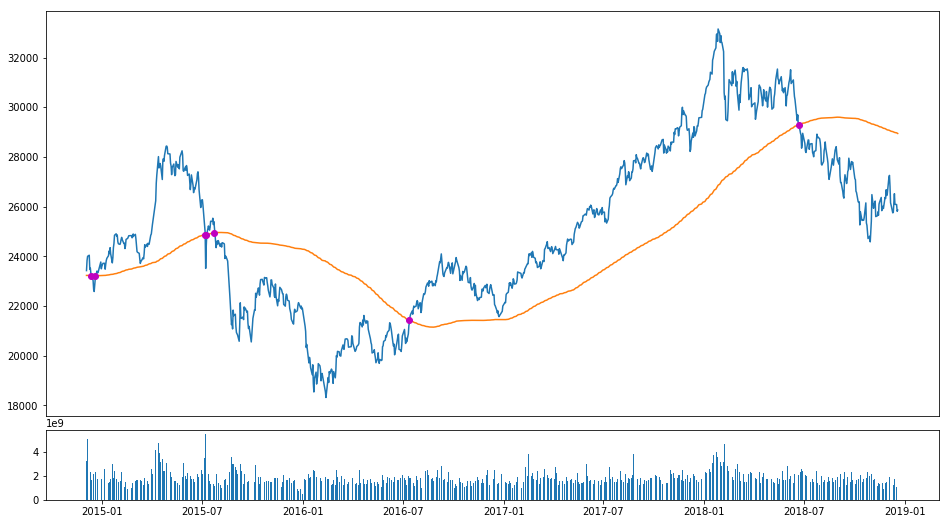

In [70]:
# -----plot a line graph hsi with 250ma and 100ma, volume-----
def simple_plotting_v2():
    #create 100ma and 250ma line
    hsi["100ma"] = hsi['Adj Close'].rolling(window=100, min_periods=0).mean()
    hsi["250ma"] = hsi['Adj Close'].rolling(window=250, min_periods=0).mean()

    ax1= plt.subplot2grid((6,1),(0,0),rowspan=5, colspan=1)
    ax2= plt.subplot2grid((6,1),(5,0),rowspan=1, colspan=1 , sharex=ax1)
    ax1.figure.set_size_inches(16,9)
    ax1.tick_params(axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    # ax2.set_title(label="Volume")
    ax1.plot(hsi.tail(1000).index,hsi['Adj Close'].tail(1000))
    ax2.bar(hsi.tail(1000).index,hsi["Volume"].tail(1000))
    ax1.plot(hsi.tail(1000).index,hsi['250ma'].tail(1000))

    idx = np.argwhere( np.diff( np.sign(hsi['250ma'].tail(1000) - hsi['Adj Close'].tail(1000)) ) ).flatten()
    ax1.plot(hsi.tail(1000).index[idx], hsi['250ma'].tail(1000)[idx], 'mo')

    plt.show()

(15000, 35000)

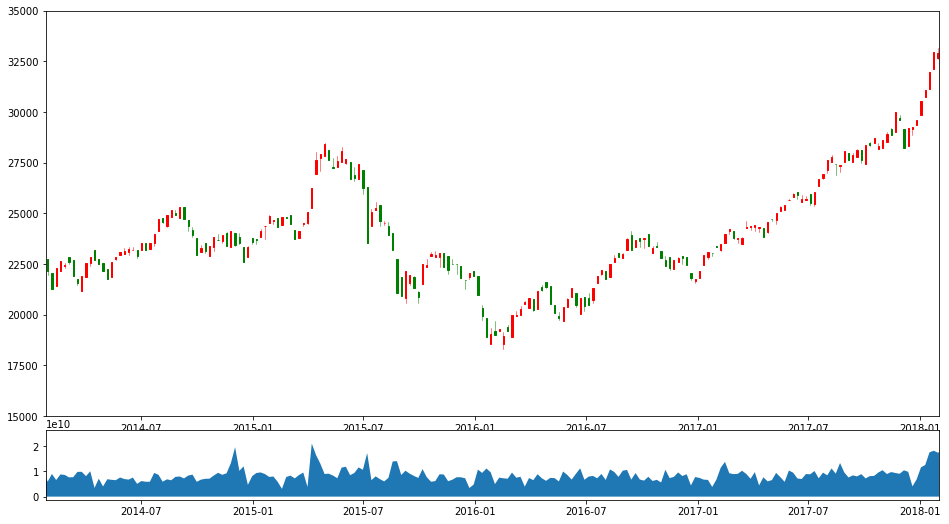

In [52]:
# -----plot a candlestick graph hsi with volume-----
def ohlc_plotting():
    # resample the data to 7 days per column
    hsi_ohlc = hsi["Adj Close"].resample('7D', closed = 'right',label = 'right').ohlc()
    hsi_volume = hsi["Volume"].resample('7D').sum()

    # convert the date index to date column
    hsi_ohlc.reset_index(inplace=True)
    hsi_ohlc["Date"]= hsi_ohlc["Date"].map(mdates.date2num)


    ax3 = plt.subplot2grid((6,1),(0,0),rowspan=5, colspan=1)
    ax4 = plt.subplot2grid((6,1),(5,0),rowspan=1, colspan=1, sharex= ax3)

    # set x axis be date
    ax3.xaxis_date()
    # ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    #plot candle stick ohlc, pass hsi_ohlc.values (time, open ,high, low , close)
    mpf.candlestick_ohlc(ax3, hsi_ohlc.values,               
                          width=2.0, colorup='r', colordown='green',
                          alpha=1.0)
    ax4.fill_between(hsi_volume.index.map(mdates.date2num),hsi_volume,0)

    ax3.figure.set_size_inches(16,9)

    # select time range required
    ax3.set_xlim([datetime.date(2014, 1, 26), datetime.date(2018, 2, 1)])
    ax3.set_ylim([15000,35000 ])

In [59]:
# -----FROM wiki: SAVE 505 common stock in sp500 to pickle "sp500_ticker_list.pickle" -----
def save_sp500_ticker_list():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    req = requests.get(url)
    soup = bs4.BeautifulSoup(req.text, "lxml")
    table = soup.find('table',{'class':"wikitable sortable"})
    tbody = table.find("tbody")
    tr = tbody.findAll("tr")
#     td = tbody.findAll('a',{"rel":"nofollow"})
    sp500_ticker_list = []
    for td in tbody.findAll('a',{"rel":"nofollow"}):
        if(td.text != 'reports'):
            sp500_ticker_list.append(td.text)
    with open("sp500_ticker_list.pickle","wb") as f:
        pickle.dump(sp500_ticker_list,f)

save_sp500_ticker_list()

In [56]:
# -----FROM YAHOO: SAVE the first 100 row of data from yahoo due to the js rendering content contraint-----
def save_pickle(name):
    # the date now
    now_time = datetime.datetime.now()
    # change the readable date to unix date, and to integer, and to string
    period2 = str( int ( time.mktime(time.strptime( str(now_time.year) +'-'+ str(now_time.month)+'-'+ str(now_time.day), '%Y-%m-%d'))))

    req = requests.get("https://finance.yahoo.com/quote/" + name + "/history?period1=315504000&period2="+ period2 +"&interval=1d&filter=history&frequency=1d") 
    soup = bs4.BeautifulSoup(req.text, "lxml")
    table = soup.find('table',{'class':"W(100%) M(0)"})
#     print(table)
    
    #read the data and put them into the data array rows by rows
    data = []
    for tr in table.findAll('tr',{'class': "BdT Bdc($c-fuji-grey-c) Ta(end) Fz(s) Whs(nw)" }):
        row = []
        for td in tr.findAll('td',{}):
            for span in td.findAll('span',{}):
                row.append(span.text)
        data.append(row)
    
    #convert the data to dataframe using pandas and numpy
    data = np.array(data)
    df = pd.DataFrame(data=data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
    
    with open(name+"_first100data.pickle","wb") as f:
        pickle.dump(df,f)
        
# save_pickle("BTC-USD")

# -----load the pickle file: first 100 row of data from yahoo due to the js rendering content contraint-----
# with open("BTC-USD_first100data.pickle","rb") as f:
#     print(pickle.load(f))

In [27]:
# -----FROM YAHOO: failed loading coz the js rendering not yet done-----
def save_pickle_dl(name):
    # the date now
    now_time = datetime.datetime.now()
    # change the readable date to unix date, and to integer, and to string
    period2 = str( int ( time.mktime(time.strptime( str(now_time.year) +'-'+ str(now_time.month)+'-'+ str(now_time.day), '%Y-%m-%d'))))
    session = HTMLSession()
    url = "https://finance.yahoo.com/quote/" + name + "/history?period1=315504000&period2="+ period2 +"&interval=1d&filter=history&frequency=1d"
    req = session.get(url)
    req.html.render()
    print(req.text)

#selenium is needed to load the js rendering content and solve the problem
# save_pickle_dl("BTC-USD")

RuntimeError: This event loop is already running

In [3]:
# -----FROM AV: SAVE daily adj data for 20 yearto pickle-----
def save_pickle_av(name):
    #extract data from av
    ts = TimeSeries(key="AUNLMRKKGTAVJMSC", output_format='pandas',indexing_type='date')
    data, meta_data = ts.get_daily_adjusted(symbol=name, outputsize='full')
    
    #save data into pickle
    filepath = "sp500_stocks/"
    filename = name+"_av.pickle"
    with open( filepath+filename , "wb") as f:
        pickle.dump(data,f)
# save_pickle_av('BTC-USD')

In [ ]:
# Save ALL SQ500 stocks into pickle from av (hv daily extract limit: 500 stocks)
# PFG (381) error
with open("sp500_ticker_list.pickle","rb") as f:
    pf = pickle.load(f)
    for i in range(381,len(pf)):
        stock = pf[i]
        done=False
        while(done == False):
            try:
    # sp500_ticker_list items use "." which is different from AV symbol list use "-"
                if "." in stock:
                    stock_no_dot = stock.replace(".","-")
                    save_pickle_av(stock_no_dot)
                else:
                    save_pickle_av(stock)
                done = True
                print("The file is done at :{}  ({})".format(stock,i))
            except:
                print("The error occur at  :{}".format(stock))


The error occur at  :PFG
The error occur at  :PFG
The error occur at  :PFG
The error occur at  :PFG
The error occur at  :PFG
The error occur at  :PFG


In [ ]:
# -----FROM AV: simple plotting all price and volume from pickle file-----
def plot_by_pickle(pickle_name):
    df = pd.read_pickle(pickle_name)
    df.index = pd.to_datetime(df.index)

    ax1= plt.subplot2grid((6,1),(0,0),rowspan=5, colspan=1)
    ax2= plt.subplot2grid((6,1),(5,0),rowspan=1, colspan=1 , sharex=ax1)
    ax1.figure.set_size_inches(16,9)
    ax1.tick_params(axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax1.set_title(label=pickle_name)
    ax1.xaxis_date()
    ax1.plot(df.index,df['5. adjusted close'])
    ax2.fill_between(df.index,df["6. volume"])
    
    #moving average
    df["100ma"] = df['5. adjusted close'].rolling(window=100, min_periods=0).mean()
    df["250ma"] = df['5. adjusted close'].rolling(window=250, min_periods=0).mean()
    #plot 250ma
    ax1.plot(df.index,df['250ma'])
    idx_250ma = np.argwhere( np.diff( np.sign(df['250ma']- df['5. adjusted close']) ) ).flatten()
    ax1.plot(df.index[idx_250ma], df['250ma'][idx_250ma], 'o')
    #plot 100ma
    ax1.plot(df.index,df['100ma'])
    idx_100ma = np.argwhere( np.diff( np.sign(df['100ma']- df['5. adjusted close']) ) ).flatten()
    ax1.plot(df.index[idx_100ma], df['100ma'][idx_100ma], 'o')
    
    # select time range required (input)
    start_yr, start_mth, start_day = 2011, 1, 26
    end_yr, end_mth, end_day = 2018, 12, 31
    # select time range required (computing)
    start_date = datetime.date(start_yr, start_mth, start_day)
    end_date = datetime.date(end_yr, end_mth, end_day)
    ax1.set_xlim([start_date, end_date])
    
    # adject the volume graph ylim with the time range
    max_vol_in_period = df.loc[ str(start_date): str(end_date), "6. volume"].max()
    ax2.set_ylim([0,max_vol_in_period])
    
    #show the line label and graph
    ax1.legend()
    ax2.legend(['volume'])
    plt.show()
plot_by_pickle("sp500_stocks/BRK-B_av.pickle")